# Open problems: single cell perturbation
## Preprocessing perturbation data
### by Jalil Nourisa

# Imports

In [1]:
import os, binascii
import scipy
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import random
import anndata as ad
import warnings

warnings.filterwarnings("ignore")
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
matplotlib.rcParams.update({'font.size': 10})
sc.settings.verbosity = 0


work_dir = f'../output'
out_edger_dir= f'{work_dir}/de_analysis/edger'
out_limma_dir= f'{work_dir}/de_analysis/limma'


bulk_index = ['sm_name', 'cell_type', 'plate_name', 'row']
CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells', 'B cells', 'Myeloid cells']
negative_control = 'Dimethyl Sulfoxide'
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
controls2 = ['Dabrafenib', 'Belinostat']
T_cell_types = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
cell_type_map = {cell_type: 'T cells' if cell_type in T_cell_types else cell_type for cell_type in CELL_TYPES}
plate_name_map = {'010':'Plate 1', '011':'Plate 2', '012':'Plate 3', '013':'Plate 4', '014':'Plate 5', '015':'Plate 6'}



colors_cell_type = ['#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray', 'red']

# load and save haousekeeping genes
df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)
housekeeping_genes = df.loc[:, 0]  # Gene names
np.savetxt(f'{work_dir}/benchmark/housekeeping_genes.txt', housekeeping_genes, fmt='%s')


## Common functions 
def plot_stacked_bar_chart(cell_types_in_drops, title='', xticks=None, 
                           xticklabels=None, colors=None, figsize=(25, 4), 
                           ax=None, legend=False, color_map=None):
    """
        Stacked bar plot to showcase the compound based distribution of cell counts. Adopted from AmbrosM. 
    """
    colors_cell_type = ['#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray', 'red']
    # Add a column of zeros to the left and compute the cumulative sums
    cc = np.hstack([np.zeros((len(cell_types_in_drops), 1)), cell_types_in_drops])
    cc_cs = cc.cumsum(axis=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    cell_types = cell_types_in_drops.columns
    for i, cell_type in enumerate(cell_types):
        if color_map is None:
            color=colors_cell_type[i]
        else:
            color=color_map[cell_type]
        ax.bar(np.arange(len(cc_cs)),
               cc_cs[:,i+1] - cc_cs[:,i],
               bottom=cc_cs[:,i],
               label=cell_types[i], color=color)
         
    ax.set_title(title)
    if xticks is not None:
        ax.set_xticks(xticks)
    else:
        ax.set_xticks(np.arange(len(cc_cs)))
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, rotation=90)
    if colors is not None:
        for ticklabel, color in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(color)
    if legend: 
        ax.legend()
    color_legend_handles = [
        matplotlib.patches.Patch(facecolor='red', label='-'),
        matplotlib.patches.Patch(facecolor='blue', label='-'),
        matplotlib.patches.Patch(facecolor='green', label='-'),
    ]
    return fig, ax

def isolation_forest(df_subset, group=['index'], cell_type_col='cell_type', values_col='cell_count'):
    """
        Identifies outlier compounds based on ratio of cell type in pseudobulked samples. 
    """
    from sklearn.ensemble import IsolationForest
    cell_count_m = df_subset.pivot(index=group, columns=cell_type_col, values=values_col)
    cell_count_ratio = cell_count_m.div(cell_count_m.sum(axis=1), axis=0)
    cell_count_ratio = cell_count_ratio.fillna(0)
    clf = IsolationForest(max_samples=100, random_state=0)
    clf.fit(cell_count_ratio.values)
    outlier_compounds = cell_count_ratio.index[clf.predict(cell_count_ratio.values)==-1]
    return outlier_compounds

def plot_scatter(obs, obs_index, xs, ys, x_label='', y_label='', log=True, log_y=False, figsize=(5, 7)):
    """
        Scatter plot to showcase the distribution of a given variable across different groups. 
    """
    n_axes = len(obs_index)
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)
    alpha = .2
    edgecolors = 'white'
    for i_index, index in enumerate(obs_index):
        # i = i_index // n_axes
        j = i_index % n_axes
        ax = axes[j]

        index_vars = obs[index]
        
        if index=='sm_name':
            # included_vars = train_sm_names
            # included_vars = index_vars.unique()
            mask = (index_vars.isin(controls2))
            ax.scatter(xs[mask], ys[mask], label='Positive control', alpha=alpha, color='cyan', edgecolors=edgecolors)
            mask = (index_vars.isin(controls2))
            ax.scatter(xs[~mask], ys[~mask], label='Rest', alpha=alpha, color='blue', edgecolors=edgecolors)
            
        else:
            included_vars = index_vars.unique()
            colors = ['blue', 'red', 'green', 'orange', 'purple', 'gray']
            for i, var in enumerate(included_vars):
                label = var
                mask = (index_vars == var)
                ax.scatter(xs[mask], ys[mask], label=var, alpha=alpha, edgecolors=edgecolors, color=colors[i])
            
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if log:
            ax.set_xscale('log')
        if log_y:
            ax.set_yscale('log')
        ax.margins(0.05)
        ax.spines[['right', 'top']].set_visible(False)
        # ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
        prop = {'size': 9}
        ax.legend(prop=prop, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.tight_layout()
    return fig, axes



# EDA on single cell data

In [93]:
sc_counts = ad.read_h5ad(f'{work_dir}/../input/sc_counts_cleaned.h5ad')
sc_counts.var_names_make_unique()
sc_counts.obs['positive_ctr'] = sc_counts.obs.sm_name.isin(controls2)

In [14]:
import sctk
# sctk.calculate_qc(sc_counts, flags={"mito": r"^MT-", "ribo": r"^RP[LS]"})
sctk.calculate_qc(sc_counts)
sctk.cellwise_qc(sc_counts)

n_counts: [2451.0716313167804, 29992.009765625], 298152/301785 passed
n_genes: [1024.870089721006, 6238.99853515625], 297247/301785 passed
percent_mito: [0.025329280644655228, 18.950448181593497], 300892/301785 passed
percent_ribo: [7.117446014036448, 51.64668405810869], 296240/301785 passed
percent_hb: [0.0, 0.00920543506616024], 191652/301785 passed
183592/301785 pass


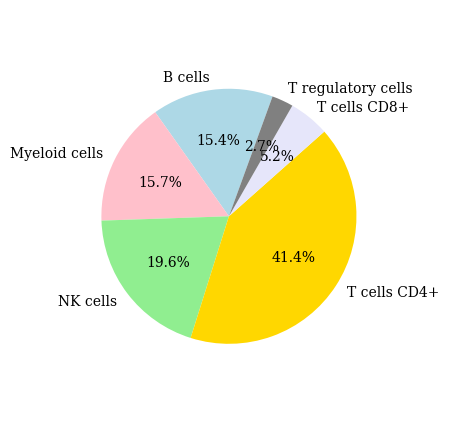

In [10]:
fig, ax = plt.subplots(1,1 , figsize=(4.5, 4.5))  # Adjust the figure size as needed
cell_count = sc_counts.obs.groupby(['sm_name', 'cell_type']).size()

sum_counts_celltypes = cell_count.reset_index().drop(columns='sm_name').groupby('cell_type').sum().reset_index()
sum_counts_celltypes_dict = sum_counts_celltypes.set_index('cell_type').to_dict()[0]
ax.pie(sum_counts_celltypes_dict.values(), labels=sum_counts_celltypes_dict.keys(), autopct='%1.1f%%', startangle=70, colors=colors_cell_type)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/celltype_raios_original.png', dpi=100, transparent=True)
plt.show()

In [94]:
# merge T cells
sc_counts.obs['cell_type'] = sc_counts.obs['cell_type'].map(cell_type_map)
sc_counts.obs['cell_type'].unique()

array(['B cells', 'T cells', 'Myeloid cells', 'NK cells'], dtype=object)

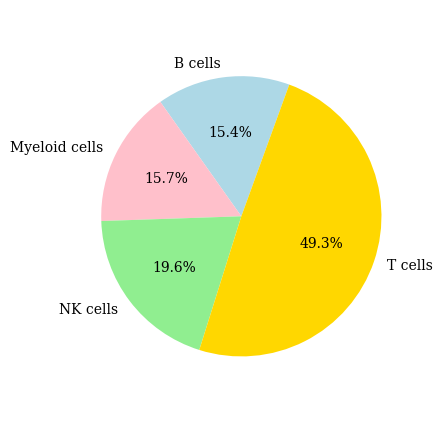

In [12]:
fig, ax = plt.subplots(1,1 , figsize=(4.5, 4.5))  # Adjust the figure size as needed
cell_count = sc_counts.obs.groupby(['sm_name', 'cell_type']).size()

sum_counts_celltypes = cell_count.reset_index().drop(columns='sm_name').groupby('cell_type').sum().reset_index()
sum_counts_celltypes_dict = sum_counts_celltypes.set_index('cell_type').to_dict()[0]
ax.pie(sum_counts_celltypes_dict.values(), labels=sum_counts_celltypes_dict.keys(), autopct='%1.1f%%', startangle=70, colors=colors_cell_type)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/celltype_raios.png', dpi=100, transparent=True)
plt.show()

In [4]:
# simplify plate name
sc_counts.obs['plate_name'] = sc_counts.obs['plate_name'].astype(str).apply(lambda name: name.split('-')[1]).astype('category')
# group cell types per well
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_name'].astype('str') \
    + '_' + sc_counts.obs['well'].astype('str') \
    + '_' + sc_counts.obs['cell_type'].astype('str')
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_well_cell_type'].astype('category')

## QC 

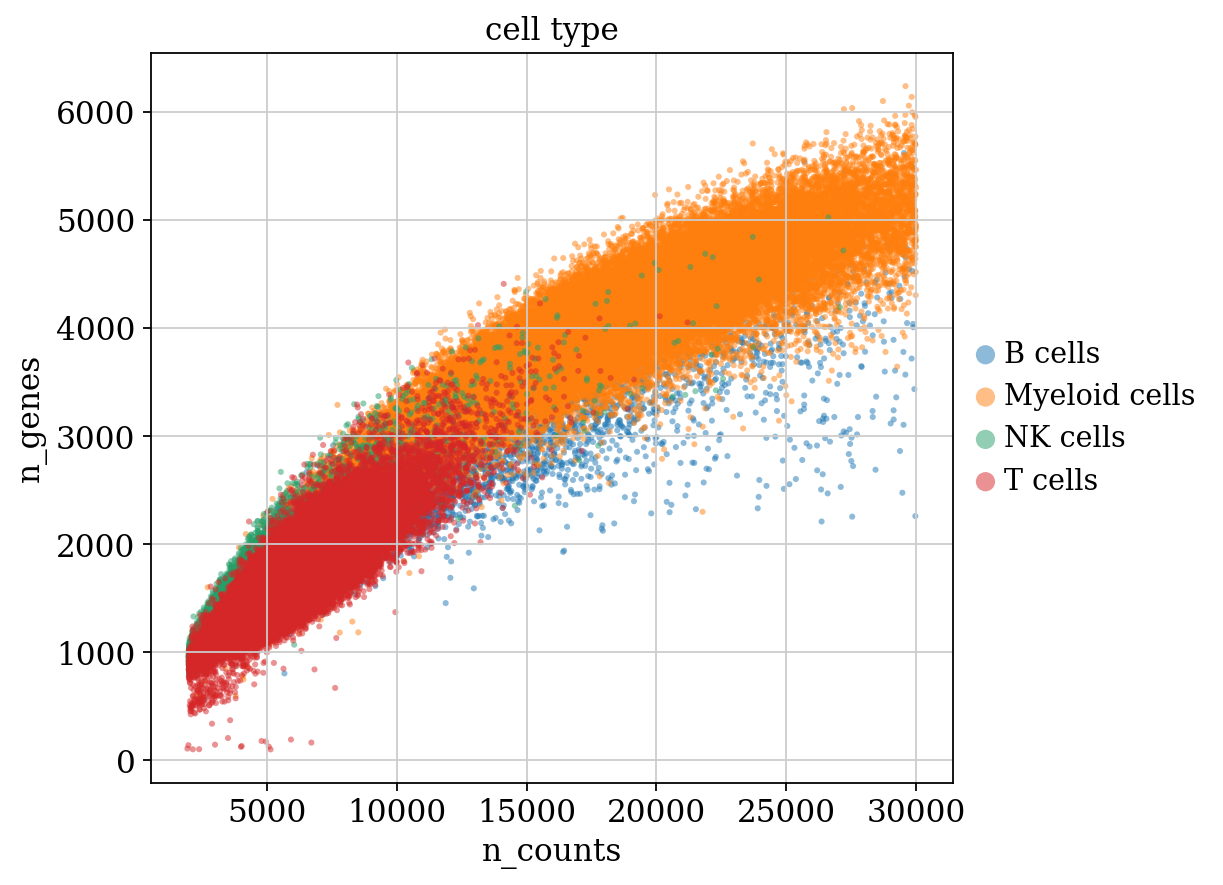

In [7]:
sc.set_figure_params(figsize=(6,6))
p3 = sc.pl.scatter(sc_counts, "n_counts", "n_genes", color="cell_type", size=30, alpha=.5)

In [9]:
sctk.default_metric_params_df

,min,max,scale,side,min_pass_rate
n_counts,1000.00,NaN,log,min_only,0.10
n_genes,100.00,NaN,log,min_only,0.10
percent_mito,0.01,20.0,log,max_only,0.10
percent_ribo,0.00,100.0,log,both,0.10
percent_hb,NaN,1.0,log,max_only,0.10
percent_soup,NaN,5.0,log,max_only,0.10
percent_spliced,50.00,97.5,log,both,0.10
scrublet_score,NaN,0.3,linear,max_only,0.95


### Cell wise

In [ ]:
def min_max(name, data):
    print(f'{name}: min:{data.min()}, max: {data.max()}')
min_max('n_counts', sc_counts.obs.n_counts)
min_max('n_genes', sc_counts.obs.n_genes)
min_max('percent_hb', sc_counts.obs.percent_hb)
min_max('percent_mito', sc_counts.obs.percent_mito)

n_counts: min:1947.0, max: 29992.0
n_genes: min:101, max: 6239
percent_hb: min:0.0, max: 95.78558943484171
percent_mito: min:0.025329280648429587, max: 20.068317677198973


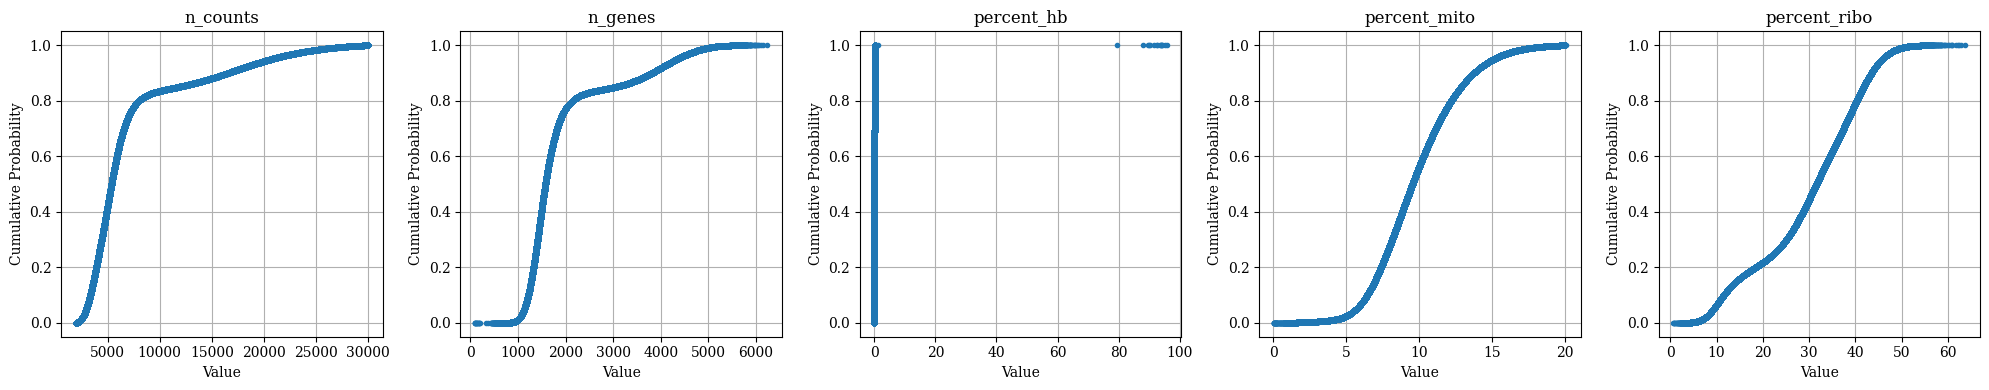

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
def plot_CDF(data, title, ax):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    ax.plot(x, y, marker='.', linestyle='none')
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    ax.grid(True)

plot_CDF(sc_counts.obs.n_counts, 'n_counts', axes[0])
plot_CDF(sc_counts.obs.n_genes, 'n_genes', axes[1])
plot_CDF(sc_counts.obs.percent_hb, 'percent_hb', axes[2])
plot_CDF(sc_counts.obs.percent_mito, 'percent_mito', axes[3])
plot_CDF(sc_counts.obs.percent_ribo, 'percent_ribo', axes[4])
plt.tight_layout()
plt.show()

In [ ]:
# for cells
print('n_counts:', sc_counts.obs.n_counts.min(), sc_counts.obs.n_counts.max())
print('n_genes:', sc_counts.obs.n_genes.min(), sc_counts.obs.n_genes.max())
print('percent_mito:', sc_counts.obs.percent_mito.min(), sc_counts.obs.percent_mito.max())
print('percent_ribo:', sc_counts.obs.percent_ribo.min(), sc_counts.obs.percent_ribo.max())
print('percent_hb:', sc_counts.obs.percent_hb.min(), sc_counts.obs.percent_hb.max())

n_counts: 1947.0 29992.0
n_genes: 101 6239
percent_mito: 0.025329280648429587 20.068317677198973
percent_ribo: 0.5988023952095809 63.80191274728154
percent_hb: 0.0 95.78558943484171


In [6]:
filter_percent_hb = sc_counts.obs.percent_hb>.2
filter_percent_hb.sum()

20

### Gene wise

In [7]:
plates = sc_counts.obs['plate_name'].unique()

# Step 2: Initialize a DataFrame to store counts
gene_counts_per_plate = pd.DataFrame(index=sc_counts.var_names, columns=plates, dtype=int)

# Step 3: Iterate over each plate and calculate expression counts
for plate in plates:
    # Subset the AnnData object for the current plate
    subset = sc_counts[sc_counts.obs['plate_name'] == plate]
    
    # Calculate expression counts (genes x cells > 0)
    expressed_genes = (subset.X > 0).sum(axis=0)
    
    # Check if the result needs conversion from sparse matrix format
    if isinstance(expressed_genes, np.matrix):
        expressed_genes = np.array(expressed_genes).flatten()
    
    # Store the counts in the DataFrame
    gene_counts_per_plate[plate] = expressed_genes

# Step 4: Aggregate counts across plates (max or sum based on the requirement)
# We use `max` here to find if any gene meets the criteria in at least one plate
max_counts = gene_counts_per_plate.max(axis=1)

# Step 5: Create a mask for genes to keep (genes expressed in at least 100 cells in any plate)
genes_to_keep = max_counts >= 100    

### Actual filtering

In [8]:
sc_counts = sc_counts[(~filter_percent_hb), genes_to_keep]

In [52]:
sc_counts

View of AnnData object with n_obs × n_vars = 301765 × 18248
    obs: 'dose_uM', 'timepoint_hr', 'well', 'row', 'col', 'plate_name', 'cell_id', 'cell_type', 'split', 'donor_id', 'sm_name', 'control', 'SMILES', 'sm_lincs_id', 'library_id', 'plate_well_cell_type', 'positive_ctr', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'cell_passed_qc'
    var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'
    uns: 'scautoqc_ranges'
    obsm: 'HTO_clr', 'X_pca', 'X_umap', 'protein_counts'

In [9]:
sc_counts.obs = sc_counts.obs[['cell_type', 'sm_name', 'donor_id', 'row', 'plate_name', 'well']]
sc_counts.var = sc_counts.var[[]]

del sc_counts.obsm
del sc_counts.uns

In [10]:
sc_counts.write(f'{work_dir}/../input/sc_counts_f.h5ad')

In [15]:
sc_counts

AnnData object with n_obs × n_vars = 301765 × 18248
    obs: 'cell_type', 'sm_name', 'donor_id', 'row', 'plate_name', 'well', 'plate_well_cell_type'

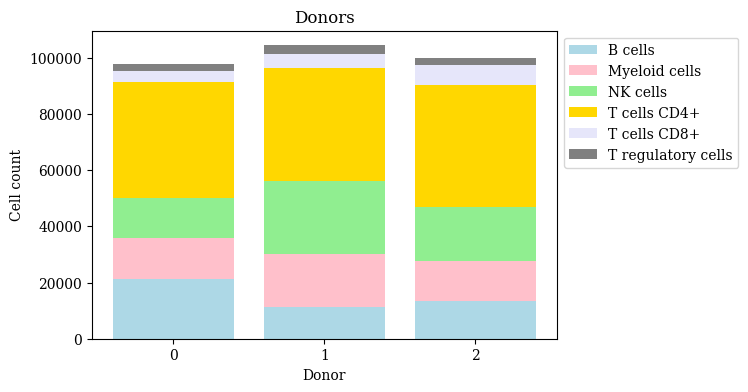

In [5]:
cell_types_ratio = sc_counts.obs.groupby('donor_id').apply(lambda df:df.groupby('cell_type').size())
fix, ax = plot_stacked_bar_chart(cell_types_ratio, title='Donors', xticks=None, 
                           xticklabels=None, colors=None, figsize=(6, 4), 
                           ax=None, legend=False, color_map=None)
ax.set_ylabel('Cell count')
ax.set_xlabel('Donor')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

# Pseudobulking counts 

In [5]:
sc_counts= ad.read_h5ad(f'{work_dir}/../input/sc_counts_f.h5ad')

In [95]:
import anndata
import pandas as pd
import numpy as np
import sklearn
import scipy
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message="The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated")
warnings.filterwarnings('ignore', category=UserWarning, message="No data for colormapping provided via 'c'")

import anndata as ad
import scanpy as sc

import matplotlib.pyplot as plt

import os, binascii
from scipy import sparse

In [96]:

def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    """
    Adapted from this forum post: 
    https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
    """
    
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    # sum `.X` entries for each unique value in `col`
    cat = adata.obs[col].values

    indicator = sparse.coo_matrix(
        (
            np.broadcast_to(True, adata.n_obs),
            (cat.codes, np.arange(adata.n_obs))
        ),
        shape=(len(cat.categories), adata.n_obs),
    )
  
    sum_adata = ad.AnnData(
        indicator @ adata.X,
        var=adata.var,
        obs=pd.DataFrame(index=cat.categories),
    )
    
    # copy over `.obs` values that have a one-to-one-mapping with `.obs[col]`
    obs_cols = adata.obs.columns
    obs_cols = list(set(adata.obs.columns) - set([col]))
    
    one_to_one_mapped_obs_cols = []
    nunique_in_col = adata.obs[col].nunique()
    for other_col in obs_cols:
        if len(adata.obs[[col, other_col]].drop_duplicates()) == nunique_in_col:
            one_to_one_mapped_obs_cols.append(other_col)

    joining_df = adata.obs[[col] + one_to_one_mapped_obs_cols].drop_duplicates().set_index(col)
    assert (sum_adata.obs.index == sum_adata.obs.join(joining_df).index).all()
    sum_adata.obs = sum_adata.obs.join(joining_df)
    sum_adata.obs.index.name = col
    sum_adata.obs = sum_adata.obs.reset_index()
    sum_adata.obs.index = sum_adata.obs.index.astype('str')

    return sum_adata

In [97]:
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_name'].astype('str') \
    + '_' + sc_counts.obs['well'].astype('str') \
    + '_' + sc_counts.obs['cell_type'].astype('str')
sc_counts.obs['plate_well_cell_type'] = sc_counts.obs['plate_well_cell_type'].astype('category')
# actuall bulking
bulk_adata = sum_by(sc_counts, 'plate_well_cell_type')
bulk_adata.obs['cell_count'] = sc_counts.obs.groupby('plate_well_cell_type').size().values
bulk_adata.X = np.array(bulk_adata.X.todense())

print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)
bulk_adata.var = bulk_adata.var.reset_index()

ratio of missingness 0.3868958551668455


In [7]:
bulk_adata.var.set_index('index', inplace=True)
bulk_adata.var.head()

""
index
A1BG
A1BG-AS1
A2M
A2M-AS1
A2MP1


In [8]:
bulk_adata.obs.cell_type.unique()

['B cells', 'Myeloid cells', 'NK cells', 'T cells']
Categories (4, object): ['B cells', 'Myeloid cells', 'NK cells', 'T cells']

In [9]:
# save
bulk_adata.write(f'{work_dir}/preprocess/bulk_adata.h5ad')

# EDA on pseudobulked data

In [9]:
bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata.h5ad')

sample_n = bulk_adata.shape[0]
gene_n = bulk_adata.shape[1]
obs_index= ['cell_type', 'sm_name']
# some preprocess
bulk_adata.X = np.nan_to_num(bulk_adata.X, nan=0)
bulk_adata

AnnData object with n_obs × n_vars = 2277 × 18248
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

In [210]:
print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)

ratio of missingness 0.2971925668826342


In [20]:
bulk_index = ['sm_name', 'cell_type', 'plate_name', 'row', 'donor_id']
bulk_adata_df = pd.DataFrame(bulk_adata.X, index= pd.MultiIndex.from_frame(bulk_adata.obs[bulk_index]), columns=bulk_adata.var.index)
sum_count = bulk_adata.X.sum(axis=1)
cell_count = bulk_adata.obs.groupby(bulk_index).apply(lambda df:df['cell_count'].sum()).reindex_like(bulk_adata_df)

bulk_adata_df.head()

index                                                        A1BG  A1BG-AS1  \
sm_name               cell_type     plate_name row donor_id                   
TIE2 Kinase Inhibitor B cells       010        A   Donor 1    1.0       5.0   
                      Myeloid cells 010        A   Donor 1    1.0      11.0   
                      NK cells      010        A   Donor 1    1.0       3.0   
                      T cells       010        A   Donor 1    5.0      12.0   
MK-5108               B cells       010        A   Donor 1    3.0       9.0   

index                                                         A2M  A2M-AS1  \
sm_name               cell_type     plate_name row donor_id                  
TIE2 Kinase Inhibitor B cells       010        A   Donor 1    0.0      0.0   
                      Myeloid cells 010        A   Donor 1   98.0      2.0   
                      NK cells      010        A   Donor 1    3.0     16.0   
                      T cells       010        A   Donor 1    4.0      9.0   
MK-5108               B cells       010        A   Donor 1    0.0      0.0   

index                                                        A2MP1  A4GALT  \
sm_name               cell_type     plate_name row donor_id                  
TIE2 Kinase Inhibitor B cells       010        A   Donor 1     0.0     2.0   
                      Myeloid cells 010        A   Donor 1     0.0     0.0   
                      NK cells      010        A   Donor 1     1.0     0.0   
                      T cells       010        A   Donor 1     1.0     0.0   
MK-5108               B cells       010        A   Donor 1     0.0     4.0   

index                                                        AAAS  AACS  \
sm_name               cell_type     plate_name row donor_id               
TIE2 Kinase Inhibitor B cells       010        A   Donor 1    9.0   6.0   
                      Myeloid cells 010        A   Donor 1   19.0   8.0   
                      NK cells      010        A   Donor 1    7.0   1.0   
                      T cells       010        A   Donor 1    9.0   4.0   
MK-5108               B cells       010        A   Donor 1    5.0   3.0   

index                                                        AAGAB   AAK1  \
sm_name               cell_type     plate_name row donor_id                 
TIE2 Kinase Inhibitor B cells       010        A   Donor 1     8.0    1.0   
                      Myeloid cells 010        A   Donor 1    43.0  119.0   
                      NK cells      010        A   Donor 1     5.0   51.0   
                      T cells       010        A   Donor 1    30.0  261.0   
MK-5108               B cells       010        A   Donor 1    11.0    5.0   

index                                                        ...  ZUP1  ZW10  \
sm_name               cell_type     plate_name row donor_id  ...               
TIE2 Kinase Inhibitor B cells       010        A   Donor 1   ...  12.0   5.0   
                      Myeloid cells 010        A   Donor 1   ...  24.0  17.0   
                      NK cells      010        A   Donor 1   ...   5.0   3.0   
                      T cells       010        A   Donor 1   ...  19.0   7.0   
MK-5108               B cells       010        A   Donor 1   ...   9.0   1.0   

index                                                        ZWILCH  ZWINT  \
sm_name               cell_type     plate_name row donor_id                  
TIE2 Kinase Inhibitor B cells       010        A   Donor 1      5.0    0.0   
                      Myeloid cells 010        A   Donor 1     24.0    8.0   
                      NK cells      010        A   Donor 1      3.0    0.0   
                      T cells       010        A   Donor 1      5.0    3.0   
MK-5108               B cells       010        A   Donor 1      0.0    0.0   

index                                                        ZXDA  ZXDB  ZXDC  \
sm_name               cell_type     plate_name row donor_id                     
TIE2 Kinase Inhi

## Initial clustering based on cell count and sum count

In [90]:
bulk_adata

AnnData object with n_obs × n_vars = 2277 × 18248
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

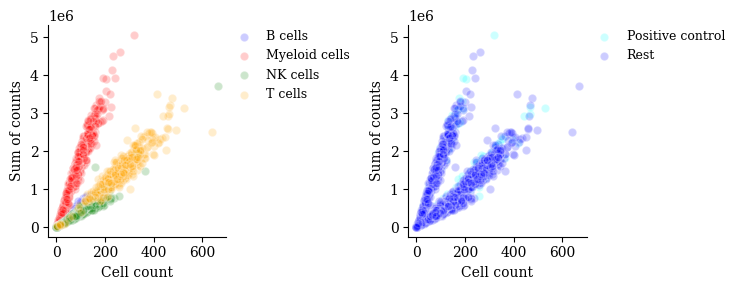

In [87]:
xs = cell_count.values
ys = sum_count
fig, axes = plot_scatter(bulk_adata.obs, obs_index, xs, ys, x_label='Cell count', y_label='Sum of counts', log=False, log_y=False,  figsize=(7.5, 3))
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/eda1_cellcount_sumcounts_raw.png', dpi=150, transparent=True)

## Cell count distribution: compound based  

In [24]:
outlier_compounds = outliers_toxic + outliers_two_celltype + outliers_misbalance_all + outliers_misbalance_donor_2 + outliers_misbalance_donor_3

In [29]:
bulk_adata

AnnData object with n_obs × n_vars = 2277 × 18248
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

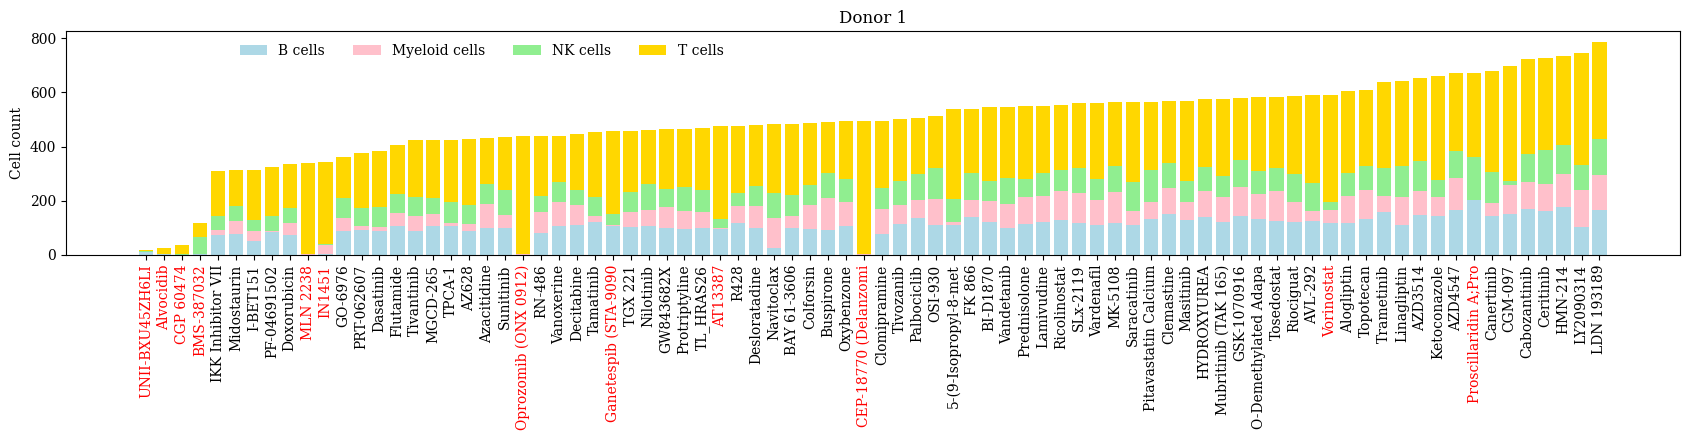

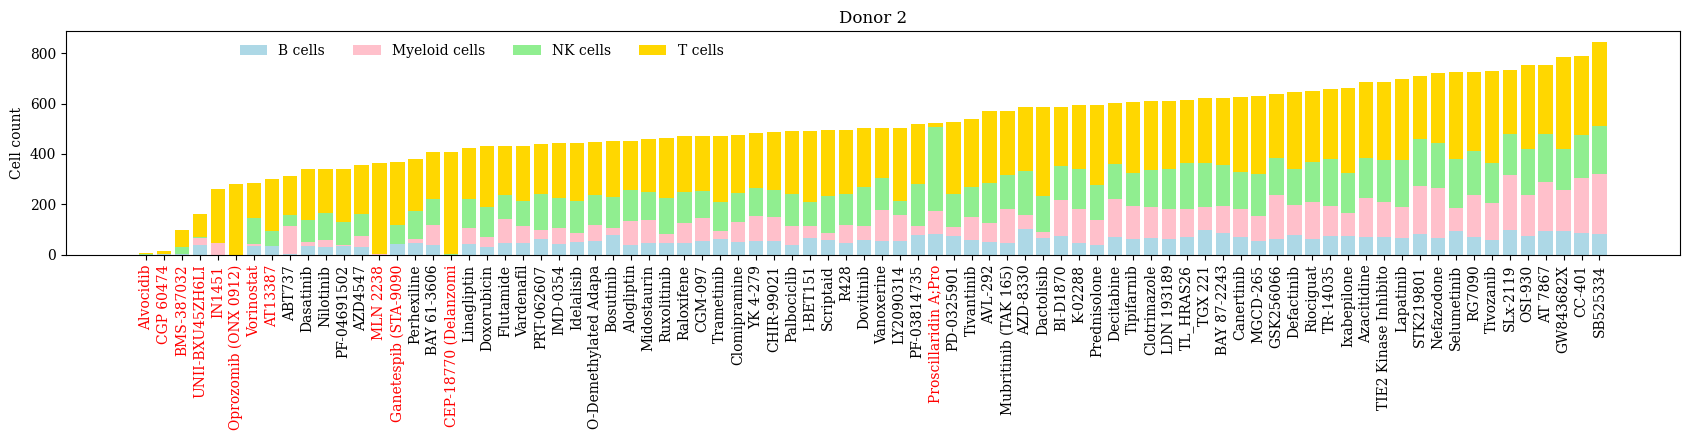

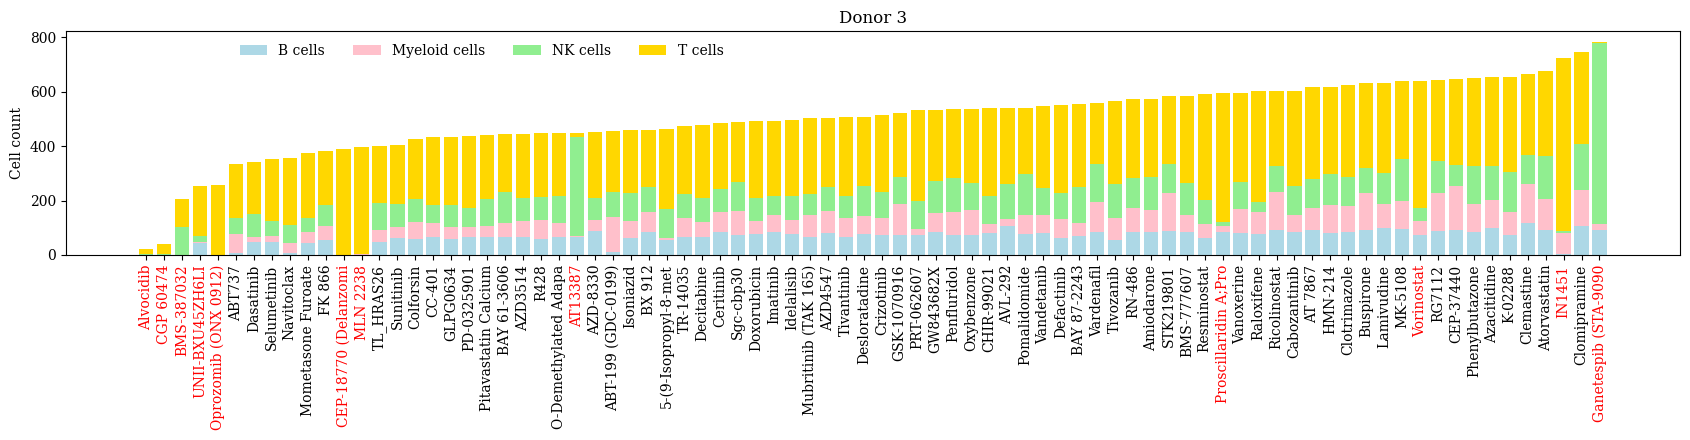

In [73]:
bulk_adata_non_controls = bulk_adata[~bulk_adata.obs.sm_name.isin(controls3), :]
donor_ids = bulk_adata.obs.donor_id.unique()
outliers_list = []
for i_donor, donor_id in enumerate(donor_ids):
    # subset and format data
    df_subset = bulk_adata_non_controls.obs[bulk_adata_non_controls.obs.donor_id==donor_id][['sm_name', 'cell_type', 'cell_count']]
    cell_count_m = df_subset.pivot(index='sm_name', columns='cell_type', values='cell_count')
    cell_count_m = cell_count_m.fillna(0)

    # outlier 
    outliers_if = isolation_forest(df_subset, group=['sm_name'])    
    outliers_list.append(outliers_if)
    
    # save the order
    # if i_donor==0:
    
    cell_count_m['sum'] = cell_count_m.sum(axis=1)
    cell_count_m = cell_count_m.sort_values('sum')
    cell_count_m = cell_count_m.drop(columns='sum')
    saved_order = cell_count_m.index
            
    # else:
    #     cell_count_m = cell_count_m.reindex(saved_order)

    colors = []
    masks = []
    for label in cell_count_m.index.values:
        if label in outlier_compounds:
            colors.append('red')
            mask = True
        else:
            colors.append('black')
            np.random.seed(32)
            mask = np.nan
        masks.append(mask)
    masks = np.asarray(masks)
    nan_mask = np.isnan(masks)
    random_bool = np.random.choice([True, False],size=nan_mask.sum())
    masks[nan_mask] = random_bool
    
    if True: # show only some of non outlier compounds
        cell_count_m['mask'] = masks
        cell_count_m['color'] = colors
        cell_count_m = cell_count_m[cell_count_m['mask']==True]
        colors = cell_count_m['color'].values
        cell_count_m = cell_count_m.drop(columns=['mask', 'color'])
    # save the order
    
    xticklabels = cell_count_m.index.values
    xticklabels = [item[0:20] for item in xticklabels]
    fig, ax = plot_stacked_bar_chart(cell_count_m, title=donor_id, xticklabels=xticklabels, colors=colors, figsize=(17, 4.5))
    ax.legend(ncol=4, frameon=False, loc='upper left', bbox_to_anchor=(.1,1))
    ax.set_ylabel('Cell count')
    plt.tight_layout()
    fig.savefig(f'{work_dir}/preprocess/figs/outliers_{donor_id}.png', dpi=150, transparent=True)

all_outliers = np.unique(np.concatenate(outliers_list))
common_outliers = list(set(outliers_list[0]).intersection(outliers_list[1], outliers_list[2]))


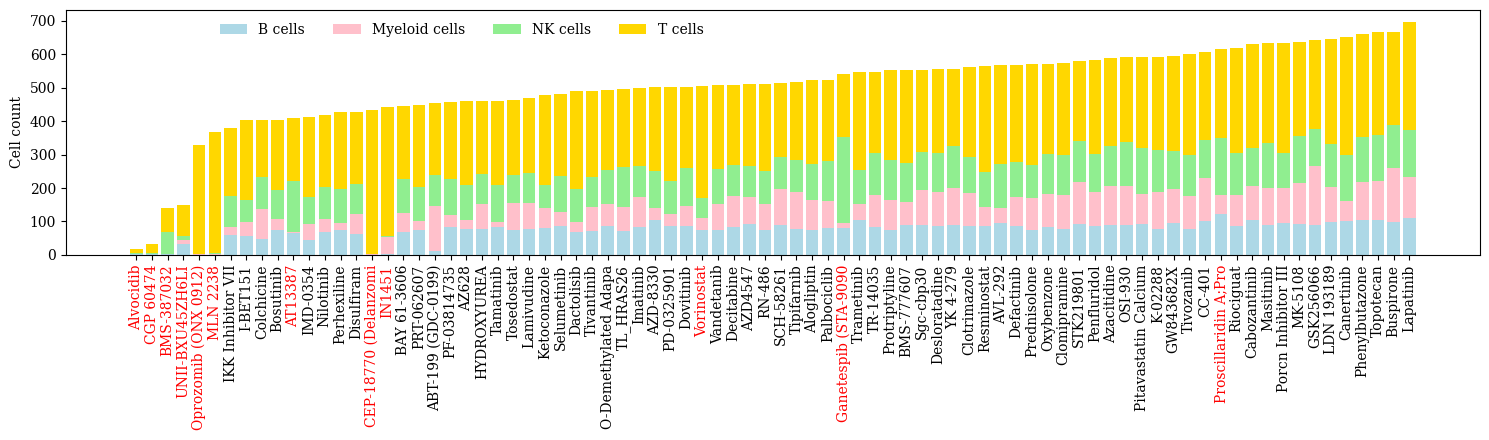

In [79]:
# average across 
df_subset = bulk_adata_non_controls.obs.groupby(['sm_name', 'cell_type']).apply(lambda df:df['cell_count'].mean()).to_frame().reset_index()
cell_count_m = df_subset.pivot(index='sm_name', columns='cell_type', values=0)
cell_count_m = cell_count_m.fillna(0)

# save the order
cell_count_m['sum'] = cell_count_m.sum(axis=1)
cell_count_m = cell_count_m.sort_values('sum')
cell_count_m = cell_count_m.drop(columns='sum')
saved_order = cell_count_m.index

colors = []
masks = []
for label in cell_count_m.index.values:
    if label in outlier_compounds:
        colors.append('red')
        mask = True
    else:
        colors.append('black')
        np.random.seed(32)
        mask = np.nan
    masks.append(mask)
masks = np.asarray(masks)
nan_mask = np.isnan(masks)
random_bool = np.random.choice([True, False],size=nan_mask.sum())
masks[nan_mask] = random_bool

if True: # show only some of non outlier compounds
    cell_count_m['mask'] = masks
    cell_count_m['color'] = colors
    cell_count_m = cell_count_m[cell_count_m['mask']==True]
    colors = cell_count_m['color'].values
    cell_count_m = cell_count_m.drop(columns=['mask', 'color'])
# save the order

xticklabels = cell_count_m.index.values
xticklabels = [item[0:20] for item in xticklabels]
fig, ax = plot_stacked_bar_chart(cell_count_m, title='', xticklabels=xticklabels, colors=colors, figsize=(15, 4.5))
ax.legend(ncol=4, frameon=False, loc='upper left', bbox_to_anchor=(.1,1))
ax.set_ylabel('Cell count')
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/outliers_mean.png', dpi=150, transparent=True)

In [22]:
# samples with less than 10 cells
bulk_adata_filtered = bulk_adata.copy()
# toxic ones
outliers_toxic = ['Alvocidib', 'UNII-BXU45ZH6LI', 'CGP 60474', 'BMS-387032']
bulk_adata_filtered = bulk_adata_filtered[~bulk_adata_filtered.obs.sm_name.isin(outliers_toxic),:]
# remove those with less than 10 cells left 
mask_low_cell_count = bulk_adata_filtered.obs.cell_count < 10
print(mask_low_cell_count.shape)
bulk_adata_filtered = bulk_adata_filtered[~mask_low_cell_count]
# remove those that has less than 2 cells types left per donor
to_go_compounds = []
for donor_id in bulk_adata_filtered.obs.donor_id.unique():
    adata_donor = bulk_adata_filtered[bulk_adata_filtered.obs.donor_id.eq(donor_id)]
    cell_type_n = adata_donor.obs.groupby('sm_name').size()
    to_go_compounds.append(cell_type_n[cell_type_n<=2].index.astype(str))
to_go_compounds = np.unique(np.concatenate(to_go_compounds))
outliers_two_celltype = ['CEP-18770 (Delanzomib)', 'IN1451', 'MLN 2238', 'Oprozomib (ONX 0912)']
assert np.all(to_go_compounds==outliers_two_celltype)
bulk_adata_filtered = bulk_adata_filtered[~bulk_adata_filtered.obs.sm_name.isin(to_go_compounds),:]

# remove big class misbalance in all donors 
outliers_misbalance_all = ['Proscillaridin A;Proscillaridin-A'] 
bulk_adata_filtered = bulk_adata_filtered[~bulk_adata_filtered.obs.sm_name.isin(outliers_misbalance_all),:]
# remove big class misbalance in 1 donor
outliers_misbalance_donor_2 = ['Vorinostat']
bulk_adata_filtered = bulk_adata_filtered[~ (bulk_adata_filtered.obs.sm_name.isin(outliers_misbalance_donor_2) & (bulk_adata_filtered.obs.donor_id=='Donor 2')),:]
outliers_misbalance_donor_3 = ['AT13387', 'Ganetespib (STA-9090)']
bulk_adata_filtered = bulk_adata_filtered[~ (bulk_adata_filtered.obs.sm_name.isin(outliers_misbalance_donor_3) & (bulk_adata_filtered.obs.donor_id=='Donor 3')),:]
 


bulk_adata_filtered

(2241,)


View of AnnData object with n_obs × n_vars = 2170 × 18248
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

2


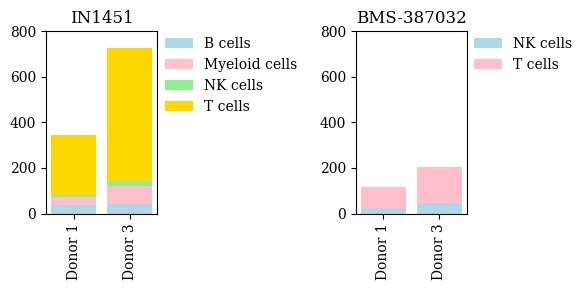

In [19]:
# # adata = ad.read('../pseudobulk_cleaned.h5ad')
# # outliers_two_celltype = ['CEP-18770 (Delanzomib)', 'IN1451', 'MLN 2238', 'Oprozomib (ONX 0912)']
# # outliers_toxic = ['Alvocidib', 'UNII-BXU45ZH6LI', 'CGP 60474', 'BMS-387032']
# # all_outliers = outliers_two_celltype + outliers_toxic
# # for sm_name in all_outliers:
# #     if sm_name in adata.obs.sm_name.unique():
# #         print(sm_name)
# group_to_plot = ['IN1451', 'BMS-387032']
# n_cols = min([5, len(group_to_plot)])
# n_rows = int(np.ceil(len(group_to_plot)/n_cols))
# print(n_cols)


# fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))

# ax_list = []
# for i_compound, compound in enumerate(group_to_plot):
#     i = i_compound // n_cols
#     j = i_compound % n_cols
#     if n_rows==1:
#         ax = axes[j]
#     else:
#         ax = axes[i][j]
#     # subset and format data
#     df_subset = adata.obs[adata.obs.sm_name==compound][['donor_id', 'cell_type', 'cell_count_by_well_celltype']]
#     cell_count_m = df_subset.pivot(index='donor_id', columns='cell_type', values='cell_count_by_well_celltype')
#     cell_count_m = cell_count_m.fillna(0)
    
#     ax.set_ylim([0, 800])
#     fig, ax = plot_stacked_bar_chart(cell_count_m, title=compound[0:20], xticklabels=cell_count_m.index.values, colors=None, figsize=(4, 4), ax=ax, legend=False)
#     ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
# plt.tight_layout()

2


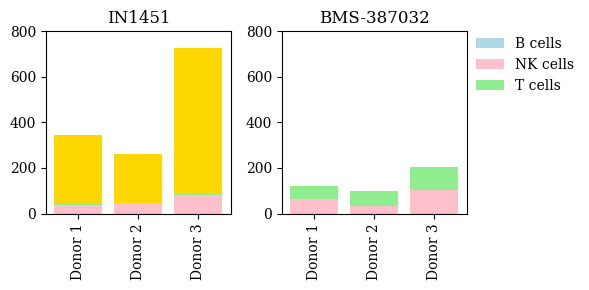

In [12]:
# group_to_plot = np.setdiff1d(all_outliers, common_outliers)
# group_to_plot = np.setdiff1d(common_outliers, included_outliers)
group_to_plot = ['IN1451', 'BMS-387032']
n_cols = min([5, len(group_to_plot)])
n_rows = int(np.ceil(len(group_to_plot)/n_cols))
print(n_cols)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))

ax_list = []
for i_compound, compound in enumerate(group_to_plot):
    i = i_compound // n_cols
    j = i_compound % n_cols
    if n_rows==1:
        ax = axes[j]
    else:
        ax = axes[i][j]
    # subset and format data
    df_subset = bulk_adata.obs[bulk_adata.obs.sm_name==compound][['donor_id', 'cell_type', 'cell_count']]
    cell_count_m = df_subset.pivot(index='donor_id', columns='cell_type', values='cell_count')
    cell_count_m = cell_count_m.fillna(0)
    
    ax.set_ylim([0, 800])
    plot_stacked_bar_chart(cell_count_m, title=compound[0:20], xticklabels=cell_count_m.index.values, colors=None, figsize=(4, 4), ax=ax, legend=False)
    ax_list.append(ax)
ax_list[-1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.tight_layout()

## Missing counts

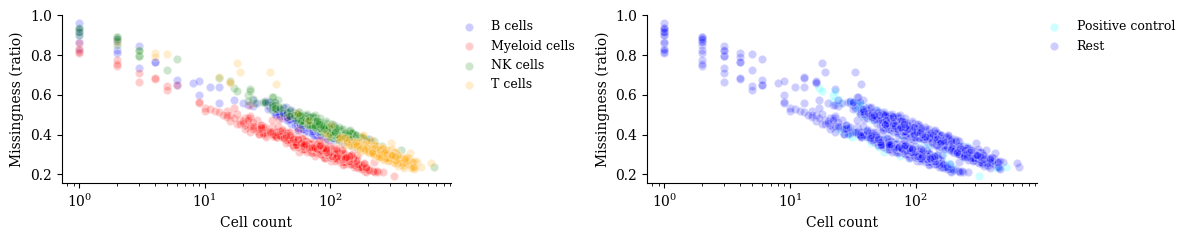

In [105]:
missingness = (bulk_adata.X == 0).sum(axis=1)/bulk_adata.X.shape[1]
bulk_adata_df = pd.DataFrame(bulk_adata.X)

xs = bulk_adata.obs.cell_count
ys = missingness



fig, axes = plot_scatter(bulk_adata.obs, ['cell_type','sm_name'], xs, ys, x_label='Cell count', y_label='Missingness (ratio)', log=True, log_y=False, figsize=(12, 2.5))
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/missigness.png', dpi=150, transparent=True)


## Low gene coverage 

In [154]:
mask_to_go_genes = ((bulk_adata_filtered.X == 0).sum(axis=0)/bulk_adata_filtered.shape[0])>0.7
mask_to_go_genes.sum()

3033

In [155]:
bulk_adata_filtered = bulk_adata_filtered[:,~mask_to_go_genes] 
bulk_adata_filtered

View of AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'well', 'plate_name', 'cell_type', 'sm_name', 'cell_count'

In [158]:
bulk_adata_filtered.write_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')

In [157]:
bulk_adata_filtered.obs.sm_name.unique().shape

(138,)

# EDA on filtered data

In [107]:
bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
bulk_adata

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'cell_type', 'sm_name', 'donor_id', 'plate_name', 'row', 'well', 'cell_count', 'plate_well_cell_type'
    layers: 'X_norm_SL', 'X_norm_pearson', 'counts'

In [108]:
print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)

ratio of missingness 0.18342316202025954


## Distribution of pseudobulkd samples per compound

In [164]:
sample_n = bulk_adata.obs.groupby(['cell_type', 'sm_name']).size().unstack('cell_type')
sample_n.fillna(0, inplace=True) # fill nans and sort for train cell type

sample_n['total'] = sample_n.sum(axis=1) # Sort by the four training cell types
sample_n.sort_values('total', inplace=True)
sample_n.tail()

cell_type,B cells,Myeloid cells,NK cells,T cells,total
sm_name,,,,,
Dasatinib,3,3,3,3,12
Dactolisib,3,3,3,3,12
Belinostat,48,48,48,48,192
Dimethyl Sulfoxide,48,48,48,48,192
Dabrafenib,48,48,48,48,192


135


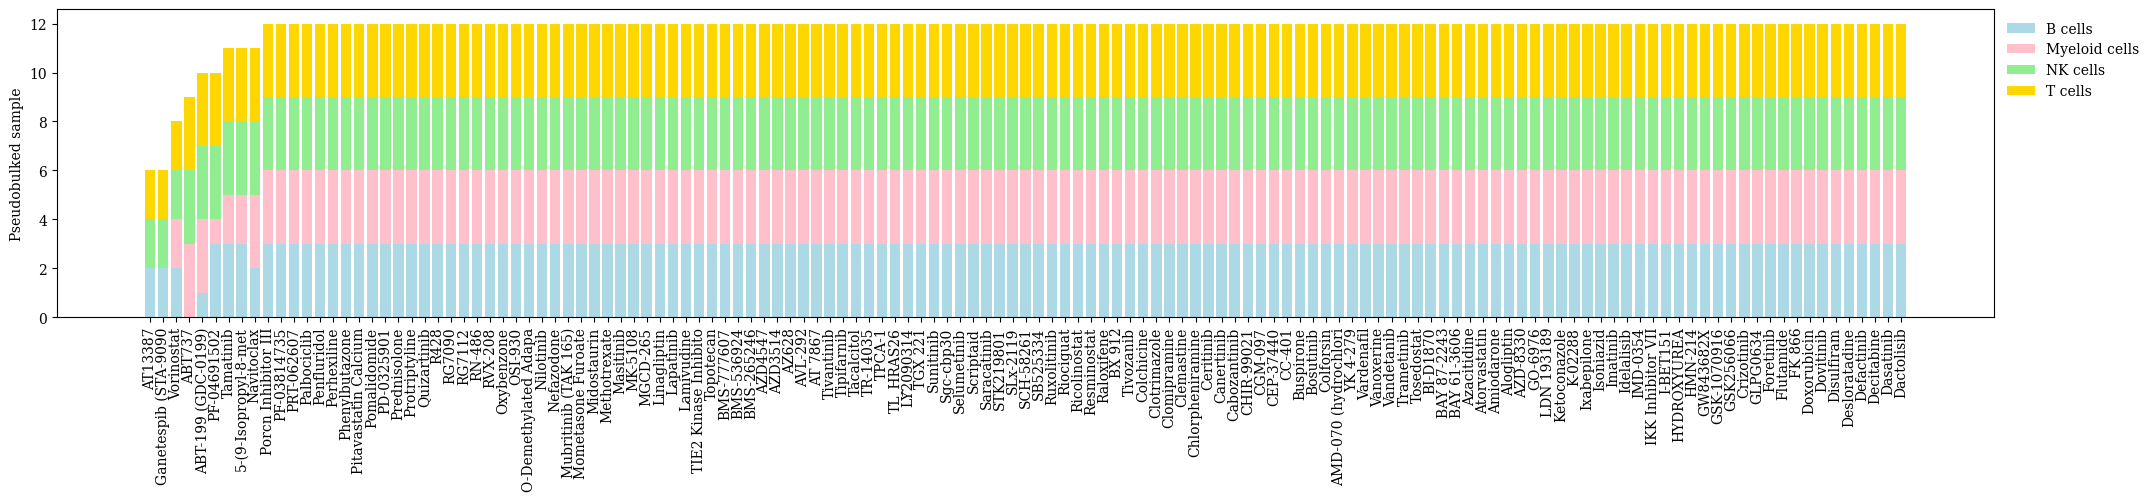

In [165]:
# Plot for non controls
cc = sample_n.loc[~sample_n.index.isin(controls3),:]
sorted_compound_names = cc.index

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = None

fig, ax = plot_stacked_bar_chart(cc[cell_types], '', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(25, 4))
ax.set_ylabel('Pseudobulked sample')
ax.legend(ncol=1, frameon=False, loc='upper left', bbox_to_anchor=(1,1))


## Highly variable genes

In [ ]:
# import anndata2ri
# anndata2ri.activate()
# %load_ext rpy2.ipython

In [ ]:
n_hvgs = 3000

In [ ]:
# %%R  -i work_dir # run this from terminal 
# library(scry)
# library(zellkonverter)
# library(SingleCellExperiment)

# work_dir = './output'
# adata <- readH5AD(paste0(work_dir, "/preprocess/bulk_adata_f.h5ad")) # raw counts
# sce = scry::devianceFeatureSelection(adata, assay="X")
# writeH5AD(sce, paste0(work_dir, "/preprocess/adata_sce.h5ad"))

In [175]:
adata_sce = ad.read(f"{work_dir}/preprocess/adata_sce.h5ad")
binomial_deviance  = adata_sce.var['binomial_deviance']
indices = binomial_deviance.argsort()[-n_hvgs:]
mask = np.zeros(adata_sce.var.shape[0], dtype=bool)
mask[indices] = True
hvgs_sce = adata_sce[:, mask].var.index.values

In [ ]:
if False:
    genes = hvgs_sce
    adata_f = bulk_adata
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)    
    var = adata_f.var
    var['sum'] = adata_f.X.sum(axis=0)
    var['std'] = adata_f.X.std(axis=0)
    mask = var.index.isin(genes)
    ax.scatter(var['sum'][mask], var['std'][mask], label='HVGs', alpha=0.4, color='cyan', edgecolors='white')
    ax.scatter(var['sum'][~mask], var['std'][~mask], label='Rest', alpha=0.4, color='Green', edgecolors='white')


    ax.set_ylabel('Std across samples')
    ax.set_xlabel('Sum across samples')
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    plt.tight_layout()
# fig.savefig(f'{work_dir}/benchmark/figs/hvgs_sum_std.png', dpi=150, transparent=True)

In [176]:
housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)
all_genes = bulk_adata.var.index.values
mask_hkgs = bulk_adata.var.index.isin(housekeeping_genes)
non_hkgs = all_genes[~mask_hkgs]
non_hkgs.shape

(11702,)

In [177]:
hvgs = hvgs_sce
genesets_dict = {'HKGs':housekeeping_genes, 'Rest': non_hkgs}
hvgs_intersection_n_dict = {}
hvgs_intersection_ratio_dict = {}
top_p_dict = {} # top percentile score versus randomly selected genes with the same dimension
n_random = 1000
for name, geneset in genesets_dict.items():
    shared_genes = np.intersect1d(geneset, all_genes)
    shared_hvgs_n = len(np.intersect1d(hvgs, shared_genes))
    shared_hvgs_ratio = shared_hvgs_n/len(shared_genes)

    hvgs_intersection_n_dict[name] = shared_hvgs_n
    hvgs_intersection_ratio_dict[name] = shared_hvgs_ratio

    # to percentile
    random_ratios = []
    for i in range(n_random):
        random_genes = np.random.choice(all_genes, shared_hvgs_n)
        random_ratios.append(len(np.intersect1d(hvgs, random_genes))/shared_hvgs_n)
    top_p = (np.asarray(random_ratios)>shared_hvgs_ratio).sum()/n_random
    top_p_dict[name] = top_p
print(f'{hvgs_intersection_ratio_dict=} \n {top_p_dict=}')

hvgs_intersection_ratio_dict={'HKGs': 0.18445772843723313, 'Rest': 0.200991283541275} 
 top_p_dict={'HKGs': 0.705, 'Rest': 0.007}


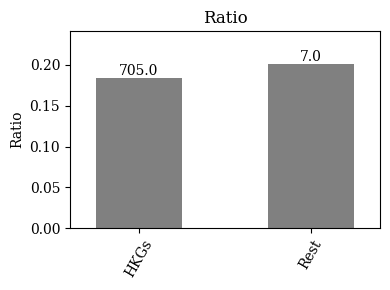

In [178]:
hvgs = hvgs_sce

fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)

def plot_bar(ax, data, y_label, title, top_p_dict=None):
    x_range = [x for x in range(len(data))]
    y_values = list(data.values())
    ax.bar(x_range, y_values, width=width, color='grey')
    ax.set_xticks(x_range)
    ax.set_xticklabels(data.keys())
    ax.tick_params(axis='x', rotation=60)
    ax.set_title(title)
    ax.margins(x=.1, y=.2)
    ax.set_ylabel(y_label)
    if top_p_dict is None:
        return 
    for i_text, value in enumerate(top_p_dict.values()):
        # if value < 0.0001:
        #     txt = '***'
        # if value < 0.001:
        #     txt = '**'
        # elif value < 0.01:
        #     txt = '*'
        # else:
        #     txt = ''
        txt = f'{value*1000}'
        ax.text(x_range[i_text], y_values[i_text], txt, ha='center', va='bottom')

width = .5

plot_bar(ax,  hvgs_intersection_ratio_dict, y_label='Ratio', title='Ratio', top_p_dict=top_p_dict)

plt.tight_layout()
plt.show()
# fig.savefig(f'{work_dir}/benchmark/figs/hvgs_stats.png', dpi=150, transparent=True)

# Normalize

In [109]:
bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
bulk_adata

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'cell_type', 'sm_name', 'donor_id', 'plate_name', 'row', 'well', 'cell_count', 'plate_well_cell_type'
    layers: 'X_norm_SL', 'X_norm_pearson', 'counts'

In [184]:
bulk_adata.layers['counts'] = bulk_adata.X.copy()

### Scanpy shifted logarithm

In [185]:
sc.pp.normalize_total(bulk_adata)
sc.pp.log1p(bulk_adata)
bulk_adata.layers['X_norm_SL'] = bulk_adata.X.copy()

### Scanpy pearson residuals
The third normalization technique we are introducing in this chapter is the analytic approximation of Pearson residuals. This normalization technique was motivated by the observation that cell-to-cell variation in scRNA-seq data might be confounded by biological heterogeneity with technical effects. The method utilizes Pearson residuals from ‘regularized negative binomial regression’ to calculate a model of technical noise in the data. 

In [186]:
bulk_adata.X = bulk_adata.layers['counts'] 
sc.experimental.pp.normalize_pearson_residuals(bulk_adata)
bulk_adata.layers['X_norm_pearson'] = bulk_adata.X.copy()


## EDA on normalized data

In [129]:
norm_tag = 'pearson' # pearson, SL
bulk_adata.X = bulk_adata.layers[f'X_norm_{norm_tag}'].copy()
obs_index = ['cell_type','sm_name']
adata_index = ['sm_name', 'cell_type', 'plate_name', 'row', 'donor_id']

adata_df = pd.DataFrame(bulk_adata.X, index= pd.MultiIndex.from_frame(bulk_adata.obs[adata_index]))
sum_count = adata_df.sum(axis=1)
cell_count = bulk_adata.obs.groupby(bulk_index).apply(lambda df:df['cell_count'].sum()).reindex_like(adata_df)
non_missing_count = (adata_df!=0).sum(axis=1)
top_quantile = (adata_df>adata_df.quantile(.95, axis=0)).sum(axis=1)/adata_df.shape[1]

if False:
    std = np.std(np.abs(adata_df), axis=1)
else:
    std = []
    for index, row in adata_df.iterrows():
        std.append(np.std(row[row!=0]))
    std = pd.DataFrame(std, index=adata_df.index)
print('sparsity', (bulk_adata.X.flatten()==0).sum()/bulk_adata.X.flatten().size)

sparsity 0.0


## Normality

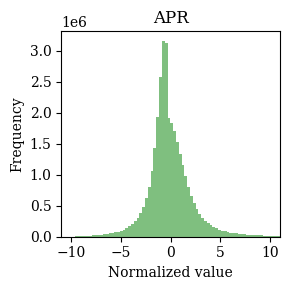

In [130]:
import matplotlib.pyplot as plt

color = 'green'
fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharey=False)
data = bulk_adata.X.flatten()
data = data[data!=0]
ax.hist(data, bins=200, color=color, alpha=.5)
ax.set_xlabel('Normalized value')
ax.set_ylabel('Frequency')
if norm_tag == 'pearson':
    ax.set_xlim([-11,11])
    title = 'APR'
elif norm_tag == 'SL':
    title = 'SL'
ax.ticklabel_format(axis='y', style='sci', useOffset=True, useMathText=False, scilimits=(0,0))  # Change 'plain' to 'sci' for scientific notation
ax.set_title(title)
plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/norm_values_hist_{norm_tag}.png', dpi=100)



## Std

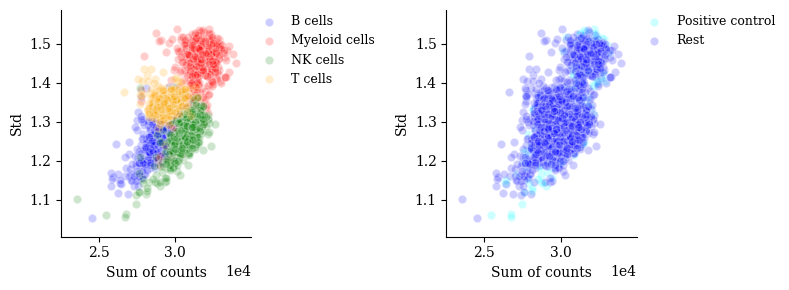

In [128]:
xs = sum_count.values
ys = std.values
fig, axes = plot_scatter(bulk_adata.obs, obs_index, xs, ys, x_label='Sum of counts', y_label='Std', log=False, figsize=(8,3))
for ax in axes:
    ax.margins(0.1)
    ax.ticklabel_format(axis='x', style='sci', useOffset=True, useMathText=False, scilimits=(0,0))  # Change 'plain' to 'sci' for scientific notation

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/std_sum_nomalized_{norm_tag}.png', dpi=100)

## Clusters

In [ ]:
bulk_adata

AnnData object with n_obs × n_vars = 2159 × 12808
    obs: 'plate_well_cell_type', 'cell_type', 'row', 'plate_name', 'well', 'sm_name', 'donor_id', 'cell_count'
    uns: 'log1p', 'pearson_residuals_normalization'
    layers: 'counts', 'X_norm_SL', 'X_norm_pearson'

In [204]:
with warnings.catch_warnings():
    sc.tl.pca(bulk_adata, svd_solver='arpack', use_highly_variable=False)
    sc.pp.neighbors(bulk_adata, n_neighbors=20, n_pcs=50)
    sc.tl.umap(bulk_adata)

In [205]:
map_names = {'donor_0':'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'} 
# adata_n_c.obs['Donor'] = adata_n_c.obs.donor_id.map(map_names)
bulk_adata.obs['Cell type'] = bulk_adata.obs.cell_type

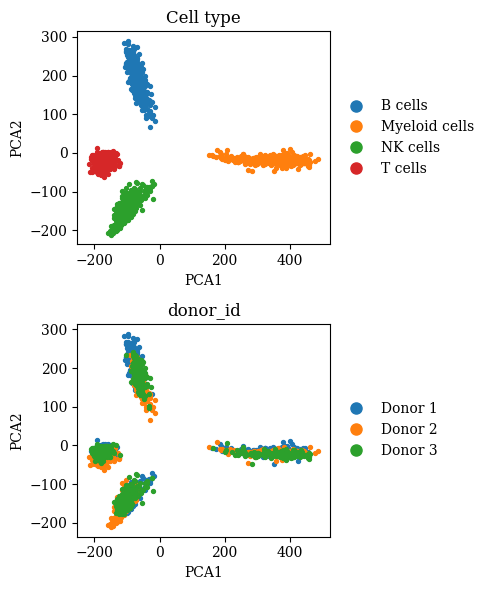

In [208]:
fig, axes = plt.subplots(2, 1, figsize=(5, 6))

def cluster_plot(adata, var, ax):
    dim_data = adata.obsm['X_pca']
    legend_handles = []  
    var_unique = sorted(adata.obs[var].unique())  
    var_unique_sorted = sorted(var_unique)  
    for sub_var in var_unique_sorted:
        mask = adata.obs[var] == sub_var
        sub_data = dim_data[mask]
        scatter = ax.scatter(sub_data[:, 0], sub_data[:, 1], label=sub_var, s=8)
        legend_handles.append(plt.Line2D([0], [0], linestyle='none', marker='o', markersize=8, color=scatter.get_facecolor()[0]))

    ax.legend(handles=legend_handles, labels=var_unique_sorted, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_title(var)

for i_ax, var in enumerate(['Cell type', 'donor_id']): 
    cluster_plot(bulk_adata, var, axes[i_ax])

plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/normalized_cluster_{norm_tag}.png', dpi=150, transparent=True)
plt.show()

In [ ]:
bulk_adata

AnnData object with n_obs × n_vars = 2159 × 12808
    obs: 'plate_well_cell_type', 'cell_type', 'row', 'plate_name', 'well', 'sm_name', 'donor_id', 'cell_count', 'Cell type'
    uns: 'log1p', 'pearson_residuals_normalization', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'X_norm_SL', 'X_norm_pearson'
    obsp: 'distances', 'connectivities'

In [200]:
bulk_adata.obs = bulk_adata.obs[['cell_type', 'sm_name', 'donor_id', 'plate_name', 'row', 'well', 'cell_count', 'plate_well_cell_type']]
bulk_adata.var = bulk_adata.var[[]]
del bulk_adata.uns 
del bulk_adata.obsm
del bulk_adata.varm
del bulk_adata.obsp
bulk_adata.X = bulk_adata.layers['counts'].copy()
bulk_adata.write(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
